In [23]:
# Jax implementation of DDPM 
# reload notebook
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append("/scr/aliang80/changepoint_aug/online_rl_diffusion/")
from ddpm_jax import Trainer, get_config
from jax import random
from absl import logging
from tqdm import tqdm
import jax.numpy as jnp
import jax

# plotting stuff
from IPython.display import clear_output
import matplotlib
matplotlib.rc('font', size=16)
matplotlib.rc('lines', linewidth=2.5)
import matplotlib.pyplot as plt
import numpy as np

def barplot_color(x, y):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(x)))
    plt.bar(x, y, color=colors)
    plt.xticks(x, labels=x)

def plt_save_fig_array(close=True, clear=True):
    fig = plt.gcf()
    fig.canvas.draw()
    res = np.array(fig.canvas.renderer.buffer_rgba())
    if close: plt.close()
    if clear: plt.clf()
    return res

def animate(clip, filename='animation.mp4', _return=True, fps=10, embed=False):
    # embed = True for Pycharm, otherwise False
    if isinstance(clip, dict):
        clip = clip['image']
    print(f'animating {filename}')
    if filename.endswith('.gif'):
        import imageio
        import matplotlib.image as mpimg
        imageio.mimsave(filename, clip)
        if _return:
            from IPython.display import display
            import ipywidgets as widgets
            return display(widgets.HTML(f'<img src="{filename}" width="750" align="center">'))
        else:
            return

    from moviepy.editor import ImageSequenceClip
    clip = ImageSequenceClip(clip, fps=fps)
    ftype = filename[-3:]
    if ftype == "mp4":
        clip.write_videofile(filename, fps=fps)
    elif ftype == "gif":
        clip.write_gif(filename, fps=fps)
    else:
        raise NotImplementedError(f"file type {ftype} not supported!")

    if _return:
        from IPython.display import Video
        return Video(filename, embed=embed, html_attributes="controls autoplay muted loop")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
config = get_config()

# setup logging
logging.set_verbosity(config.log_level)

# setup rng
model_rng, _ = random.split(random.PRNGKey(config.seed))

# setup trainer
trainer = Trainer(model_rng, **config.experiment_kwargs)

INFO:absl:Devices: [cuda(id=1), cuda(id=2), cuda(id=3), cuda(id=4), cuda(id=5), cuda(id=6), cuda(id=7)]
INFO:absl:Device count: 7
INFO:absl:Running on platform: gpu
INFO:absl:Using data type: <class 'jax.numpy.float32'>


INFO:absl:Parameter count: 1121


In [21]:
# rng = jax.random.PRNGKey(0)
# rng_sample, _ = random.split(rng)
# input = jax.random.normal(rng_sample, (10, 1))
trainer.step(batch_size=5)

({'ddpm_loss': Array([[0.15976068],
         [2.2806811 ],
         [1.9906206 ],
         [0.04181573],
         [0.15390247],
         [0.12989584],
         [0.13438724],
         [0.5176568 ],
         [0.84450877],
         [0.30258098]], dtype=float32),
  'reward': Array([[1.0853542 ],
         [0.9974519 ],
         [1.0889456 ],
         [1.0920541 ],
         [0.8940539 ],
         [0.97022927],
         [1.0985057 ],
         [1.0987397 ],
         [1.0168175 ],
         [1.0953062 ]], dtype=float32)},
 {'step': 1, 'epoch': 0, 'learning_rate': 0.0001})

# Reward function

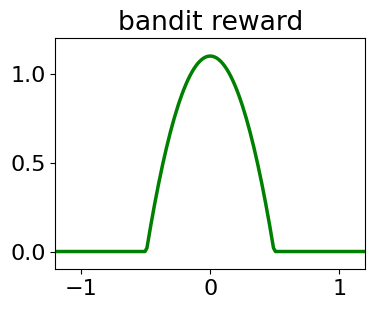

In [25]:
# feel free to try different reward functions
def reward(x):
    y1 = jnp.clip(-18 * (0.5 * x) ** 2 + 1.1, a_min=0)
    # y2 = torch.clip(-0.125 * (2 * x - 1.75) ** 2 + 0.5, min=0)
    # y2 = y2 * (x < 1.75 / 2).float()
    return y1

# def reward(x):
#     y1 = torch.clip(-18 * (2 * x + 1.2) ** 2 + 1.1, min=0)
#     y2 = torch.clip(-0.125 * (4 * x - 1.75) ** 2 + 0.5, min=0)
#     # y2 = y2 * (x < 1.75 / 4).float()
#     return y1 + y2

def plot_reward(x, y):
    plt.xlim(-1.2, 1.2); plt.ylim(-0.1, 1.2)
    plt.plot(x.reshape(-1), y.reshape(-1), color='green')

# visualize reward landscape
plt.figure(figsize=(4, 3))
plt.title("bandit reward")
x = jnp.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
plt.show()

# Visualize distribution of actions from diffusion policy

-1.0 1.0


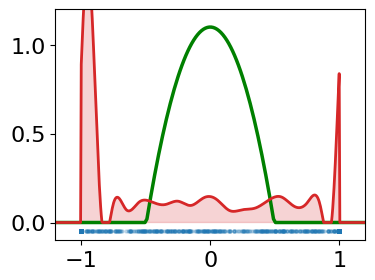

In [56]:
from scipy.interpolate import make_interp_spline

# visualize the distribution of actions
def dist_hist(actions, bins):
    x_freq = np.linspace(-2.5, 2.5, bins + 1)
    inds = np.digitize(actions, x_freq)
    freq = np.zeros_like(x_freq)
    unique, counts = np.unique(inds, return_counts=True)
    for i, count in zip(unique, counts):
        freq[i-1] = count
    freq = freq / freq.sum() * 2
    return x_freq + (x_freq[1] - x_freq[0]) / 2, freq * 2.4

def visualize_diffusion_policy(trainer, sample_rng, batch_size=10000, pdf_scale=1):
    actions = trainer.sample(batch_size, steps=config.experiment_kwargs.config.diffusion.T, rng=sample_rng)
    print(actions.min(), actions.max())
    plt.scatter(actions, np.zeros_like(actions) - 0.05, s=5, alpha=0.2)
    plt.clim(actions.min(), actions.max())
    x_freq, freq = dist_hist(actions, bins=50)
    X_Y_Spline = make_interp_spline(x_freq, freq)
    X_ = np.linspace(x_freq.min(), x_freq.max(), 1000)
    Y_ = np.clip(X_Y_Spline(X_), a_min=0, a_max=None)
    # spline interpolates out of the action bound, it looks confusing
    Y_[np.abs(X_) > 1] = 0
    Y_ *= pdf_scale
    plt.plot(X_, Y_, color='C3', linewidth=2)
    plt.fill_between(X_, Y_, color='C3', alpha=0.2)

plt.figure(figsize=(4, 3))
# visualize reward landscape
x = jnp.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
visualize_diffusion_policy(trainer, batch_size=1000, sample_rng=jax.random.PRNGKey(0))
plt.show()

nan nan


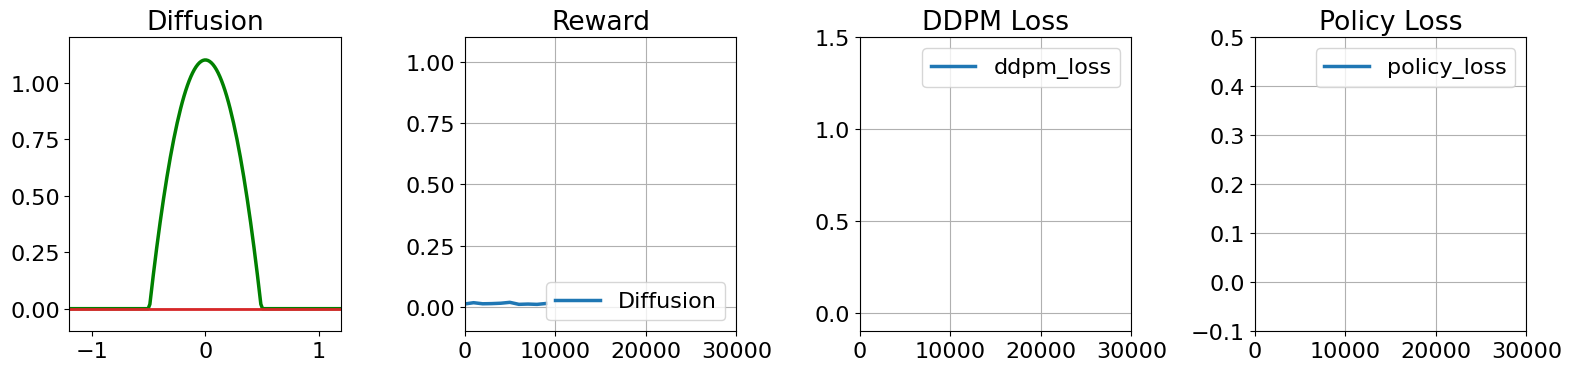

KeyboardInterrupt: 

In [66]:
visualize_every = 1000
ddpm_loss = []
policy_loss = []
rewards = []
video_imgs = []
T = config.steps
sample_rng = jax.random.PRNGKey(0)

for t in range(config.steps + 1):

    metrics, meta = trainer.step()

    # visualize
    if t % visualize_every == 0:
        clear_output(wait=True)
        total_plots = 4
        fig_width = 4
        plt.figure(figsize=(total_plots * fig_width, fig_width))
        rewards.append(metrics["reward"])
        ddpm_loss.append(metrics["ddpm_loss"])
        policy_loss.append(metrics["policy_loss"])

        # visualize Gaussian-Reinforce
        plt.subplot(1, total_plots, 1)
        plt.title("Diffusion")
        x = jnp.linspace(-1.5, 1.5, 200)
        y = reward(x)
        plot_reward(x, y)
        sample_rng, rng = random.split(sample_rng)
        visualize_diffusion_policy(trainer, rng, batch_size=256)

        # visualize reward
        plt.subplot(1, total_plots, 2)
        plt.xlim(0, T); plt.ylim(-0.1, 1.1)
        plt.title("Reward")
        plt.plot(np.arange(len(rewards)) * visualize_every, rewards, color="C0", label="Diffusion")
        plt.grid()
        plt.legend(loc="lower right")

        # visualize ddpm loss
        plt.subplot(1, total_plots, 3)
        plt.xlim(0, T); plt.ylim(-0.1, 1.5)
        plt.title("DDPM Loss")
        plt.plot(np.arange(len(ddpm_loss)) * visualize_every, ddpm_loss, label="ddpm_loss")
        plt.grid()
        plt.legend(loc="upper right")

        # visualize policy loss
        plt.subplot(1, total_plots, 4)
        plt.xlim(0, T); plt.ylim(-0.1, 0.5)
        plt.title("Policy Loss")
        plt.plot(np.arange(len(policy_loss)) * visualize_every, policy_loss, label="policy_loss")
        plt.grid()
        plt.legend(loc="upper right")

        plt.tight_layout()
        video_imgs.append(plt_save_fig_array(close=False, clear=False))
        plt.show()
